## Modelo New Keynesian básico

Este notebook muestra cómo computar el modelo New keynesian básico. La derivación se encuentra en las notas de clases.

Las condiciones de equilibrio log-linealizadas son
\begin{align}
    E_t \left[ \hat{y}_{t+1} + \frac{1}{\sigma} \left( \hat{\pi}_{t+1} - \hat{R}_{t} \right) \right] = & \hat{y}_{t} \\
        \beta E_t \left[  \hat{\pi}_{t+1} \right] = & \hat{\pi}_{t} - \kappa\left[ (\nu + \sigma ) \hat{y}_{t} - (1+\nu)\hat{A}_t \right] \\
     E_t \left[  \hat{R}_{t} \right] = & (1-\rho_R)\left[ \phi_\pi \hat{\pi}_{t} + \phi_y \hat{y}_{t}  \right] + \rho_R \hat{R}_{t-1} + v_t \\
     E_t \left[  \hat{A}_{t+1} \right] = & \rho_A \hat{A}_{t} \\
     E_t \left[  v_{t+1} \right] = & \rho_v v_{t}
\end{align}
Definimos el vector de variables $z_t$ como
\begin{equation}
    z_t = \left[ \hat{R}_{t-1} \; \hat{A}_t \; v_t \; \hat{y}_t \; \hat{\pi}_t \right]^{\prime}
\end{equation}

We want to express the solution in the form
\begin{equation}
     A E_t \left[ z_{t+1} \right] = B \left[ z_{t} \right]
\end{equation}

The matrices $A$ and $B$ are:
\begin{equation}
    A = \begin{bmatrix}
         -1/\sigma & 0 & 0 & 1 & 1/\sigma \\
         0 & 0 & 0 & 0 & \beta  \\
         1 & 0 & 0 & 0 & 0   \\
         0 & 1 & 0 & 0 & 0   \\
         0 & 0 & 1 & 0 & 0  
    \end{bmatrix}    
\end{equation}

\begin{equation}
        B = \begin{bmatrix}
         0 & 0 & 0 & 1 & 0  \\
         0 & \kappa(1+\nu) & 0 & -\kappa(1+\nu) & 1   \\
         \rho_R & 0 & 1 & (1-\rho_R)\phi_y & (1-\rho_R)\phi_\pi \\
         0 & \rho_A & 0 & 0 & 0 \\
         0 & 0 & \rho_v & 0 & 0
    \end{bmatrix}
\end{equation}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import sys
import statsmodels.api as sm


%matplotlib inline

plt.rcParams['figure.figsize'] = (10,6)


In [2]:
# PARAMETER VALUES

# PREFERENCES
β = 0.95   # Discount factor
ν = 1      # Reciprocal Frisch elasticity of labor supply
η = 1      # Constant multiplying labor disutility
σ = 2      # Risk aversion coefficient
ψ = 0.01   # Constant multiplying money in preferences
ξ = 2      # Parameter in exponent of money demand

# PRODUCTION SIDE
θ = 6      # Elasticity of substitution / Demand elasticity of intermediate inputs
ω = 25     # Parameter of quadratic price adjustment cost in intermediate good firms

# MONETARY POLICY RULE
π_bar = 1    # Steady state gross inflation rate
ρ_R   = 0.5  # Smoothing parameter Taylor rule 

ϕ_π = 1.5    # Reaction to inflation
ϕ_y = 0.25   # Reaction to output

# SHOCKS
ρ_A = 0.95   # Persistence of productivity shock
σ_A = 0.01   # Standard deviation of productivity shock

ρ_v = 0.95   # Persistence of monetary pocliy  shock
σ_v = 0.01   # Standard deviation of monetary policy shock


# Derived parameter in the Phillips curve
κ = (θ-1)/(π_bar**2 * ω)  


# ----------------------------------------------
# STEADY STATE
Rbar  = π_bar/β
ybar  = ((1/η)*((θ-1)/θ) )**(1/(σ+ν))
mbar = (ψ*ybar**σ * Rbar/(Rbar-1) )**( 1/ξ )
Abar = 1
vbar = 0 

# -----------------------------------------------
# PRINT PARAMETERS AND STEADY STATE
# Display calibrated paramters
print(" PARAMETROS CALIBRADOS \n --------------------- ")
print(f"  β   =  {β:.2f}")
print(f"  η   =  {η:.2f}")
print(f"  ν   =  {ν:.2f}")
print(f"  σ   =  {σ:.2f}")
print(f"  ψ   =  {ψ:.2f}")
print(f"  ξ   =  {ξ:.2f}")
print(f"  θ   =  {θ:.2f}")
print(f"  ω   =  {ω:.2f}")
print(f"  ρ_R =  {ρ_R:.2f}")
print(f"  ϕ_π =  {ϕ_π:.2f}")
print(f"  ϕ_y =  {ϕ_y:.2f}")
print(f"  ρ_A =  {ρ_A:.2f}")
print(f"  σ_A =  {σ_A:.2f}")
print(f"  ρ_v =  {ρ_v:.2f}")
print(f"  σ_v =  {σ_v:.2f}")
print(f"  π_bar =  {π_bar:.2f}")


print("\n\n VALORES DE ESTADO ESTACIONARIO \n ------------------------------ ")
print(f"  Output        = {ybar:.2f}")
print(f"  Interest rate = {Rbar:.2f}")
print(f"  M/P           = {mbar:.2f}")



 PARAMETROS CALIBRADOS 
 --------------------- 
  β   =  0.95
  η   =  1.00
  ν   =  1.00
  σ   =  2.00
  ψ   =  0.01
  ξ   =  2.00
  θ   =  6.00
  ω   =  25.00
  ρ_R =  0.50
  ϕ_π =  1.50
  ϕ_y =  0.25
  ρ_A =  0.95
  σ_A =  0.01
  ρ_v =  0.95
  σ_v =  0.01
  π_bar =  1.00


 VALORES DE ESTADO ESTACIONARIO 
 ------------------------------ 
  Output        = 0.94
  Interest rate = 1.05
  M/P           = 0.42


### Write the first order conditions as a system of first order expectational linear difference equations

We want to express the solution in the form
\begin{equation}
     A E_t \left[ z_{t+1} \right] = B \left[ z_{t} \right]
\end{equation}

The matrices $A$ and $B$ are:
\begin{equation}
    A = \begin{bmatrix}
         -1/\sigma & 0 & 0 & 1 & 1/\sigma \\
         0 & 0 & 0 & 0 & \beta  \\
         1 & 0 & 0 & 0 & 0   \\
         0 & 1 & 0 & 0 & 0   \\
         0 & 0 & 1 & 0 & 0  
    \end{bmatrix}    
\end{equation}

\begin{equation}
        B = \begin{bmatrix}
         0 & 0 & 0 & 1 & 0  \\
         0 & \kappa(1+\nu) & 0 & -\kappa(1+\nu) & 1   \\
         \rho_R & 0 & 1 & (1-\rho_R)\phi_y & (1-\rho_R)\phi_\pi \\
         0 & \rho_A & 0 & 0 & 0 \\
         0 & 0 & \rho_v & 0 & 0
    \end{bmatrix}
\end{equation}

In [3]:
# CONSTRUCT MATRICES A AND B

A = np.zeros((5,5))
B = np.zeros((5,5))

# FILL ELEMENTS OF A MATRIX (remember that indexes start in 0)

#   Equation 1
A[0,0] = -1/σ              # R(t)
A[0,3] = 1                 # y(t+1)
A[0,4] = 1/σ               # π(t+1)

#   Equation 2
A[1,4] = β                 # π(t+1)

#   Equation 3
A[2,0] = 1                 # R(t)

#   Equation 4
A[3,1] = 1                 # A(t+1)

#   Equation 5
A[4,2] = 1                 # v(t+1)


# FILL ELEMENTS OF THE B MATRIX 

# Equation 1:
B[0,3] = 1        # y(t)

# Equation 2:
B[1,1] = κ*(1+ν)  # R(t)
B[1,3] = -κ*(ν+σ) # v(t)
B[1,4] = 1        # π(t)

# Equation 3:
B[2,0] = ρ_R           # R(t)
B[2,2] = 1             # v(t)
B[2,3] = (1-ρ_R)*ϕ_y   # y(t)
B[2,4] = (1-ρ_R)*ϕ_π   # π(t)

# Equation 4:
B[3,1] = ρ_A        # A(t)

# Equation 5:
B[4,2] = ρ_v        # v(t)

In [4]:
def solve_ab( A, B, n ):
# SOLVE A FIRST ORDER DIFFERENCE EQUATION USING THE QZ DECOMPOSITION AS IN KLEIN (2000)
# Solves the system A E_t[z_{t+1}] = B z_{t} using the QZ decomposition
# Inputs:
#   A: square matrix
#   B: square matrix (same size as A)
#   n: number of state variables
#
# Note: this is probably not the most efficient implementation of the algorithm.

    S, T, alpha, beta, Q, Z = linalg.ordqz(A, B, sort='ouc')

    Z21 = Z[n:,0:n]
    Z11 = Z[0:n,0:n]

    
    # CHECK BLANCHARD-KAHN CONDITIONS. If violated, send a message and stop.
    
    # Generalized eigenvalues
    geiv  = np.abs(beta/alpha) # Absolute value of generalized eigenvalues
    ngest = np.sum(geiv < 1)   # Number of stable generalized eigenvalues

    if ngest<n:
        sys.exit('Blanchard and Kahn condition violated: no existence of equilibrium')

    if ngest>n:
        sys.exit('Blanchard and Kahn condition violated: multiple equilibria. Think for a moment what you want to do with this')

    # FIND SOLUTION
    if np.linalg.matrix_rank(Z11) < n:
            sys.exit('Invertibility condition violated')

    Z11i = linalg.inv(Z11)
    S11  = S[0:n,0:n]
    T11  = T[0:n,0:n]

    if ( np.abs( T[n-1,n-1] ) > np.abs( S[n-1,n-1] ) ) | ( np.abs(T[n,n]) < np.abs(S[n,n]) ):
            print("Wrong number of stable eigenvalues.")

    S11i = linalg.inv(S11)        

    F = np.real(Z21@Z11i)
    P = np.real(Z11@ ( (S11i@T11) @ Z11i ))

    
    return F, P

In [5]:
# Solve model and find policy functions

n = 3  # 3 state variables
F, P = solve_ab( A, B, n ) 

print(" Control variables policy functions of the NK model: Matrix F ")
print(F)

print(" \n State variables policy functions of the NK  model: Matrix P ")
print(P)


varnames =['R',
           'A',
           'v',
           'Output',
           'Inflation']


 Control variables policy functions of the NK model: Matrix F 
[[-0.26318277  0.50064462 -1.28404966]
 [-0.22120492 -0.44202447 -3.71153817]]
 
 State variables policy functions of the NK  model: Matrix P 
[[ 3.01198467e-01 -2.68937773e-01 -1.94415984e+00]
 [ 0.00000000e+00  9.50000000e-01 -4.19423895e-16]
 [ 0.00000000e+00  0.00000000e+00  9.50000000e-01]]


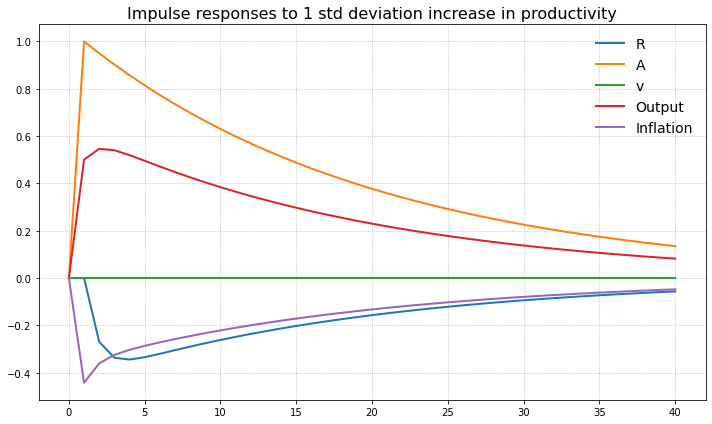

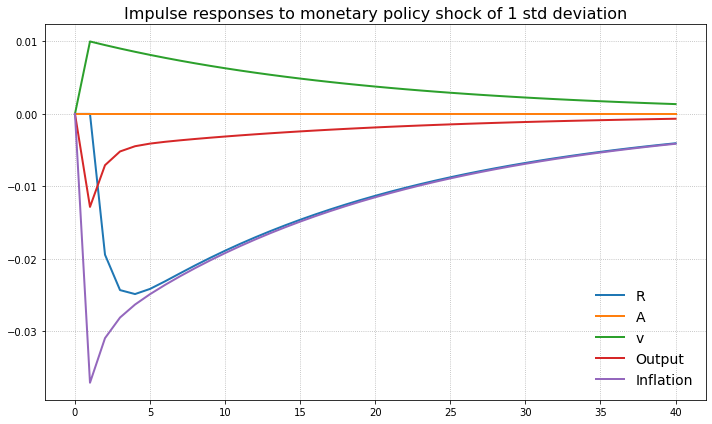

In [7]:
# COMPUTE IMPULSE RESPONSES

#  Number of periods to simulate the model
T = 41

#  IMPULSE TO A TECHNOLOGY SHOCK
#  Initialize storage arrays
irr_a = np.zeros(T+1)
ira_a = np.zeros(T+1)
irv_a = np.zeros(T+1)
iry_a = np.zeros(T)
irπ_a = np.zeros(T)

ϵ_shock = np.zeros(T+1)
ϵ_shock[0] = 100*σ_A  # impulso de 1 std deviation

for t in range(T):
    # Evolution of states
    irr_a[t+1] = irr_a[t]*P[0,0] + ira_a[t]*P[0,1] + irv_a[t]*P[0,2]
    ira_a[t+1] = irr_a[t]*P[1,0] + ira_a[t]*P[1,1] + irv_a[t]*P[1,2] + ϵ_shock[t]
    irv_a[t+1] = irr_a[t]*P[2,0] + ira_a[t]*P[2,1] + irv_a[t]*P[2,2]
    
    # Evolution of controls:
    iry_a[t]   = irr_a[t]*F[0,0] + ira_a[t]*F[0,1] + irv_a[t]*F[0,2]
    irπ_a[t]   = irr_a[t]*F[1,0] + ira_a[t]*F[1,1] + irv_a[t]*F[1,2]


# MAKE PLOT    
fig, ax = plt.subplots()
ax.set_title('Impulse responses to 1 std deviation increase in productivity', fontsize = 16)
ax.plot(irr_a[:-1], linewidth = 2, label = varnames[0])
ax.plot(ira_a[:-1], linewidth = 2, label = varnames[1])
ax.plot(irv_a[:-1], linewidth = 2, label = varnames[2])
ax.plot(iry_a, linewidth = 2, label = varnames[3])
ax.plot(irπ_a, linewidth = 2, label = varnames[4])
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.savefig("IR_ProductivityShock_NewKeynesian.pdf", format="pdf", bbox_inches="tight")
plt.show()
    
    
#  IMPULSE TO A MONETARY POLICY SHOCK
#  Initialize storage arrays
irr_v = np.zeros(T+1)
ira_v = np.zeros(T+1)
irv_v = np.zeros(T+1)
iry_v = np.zeros(T)
irπ_v = np.zeros(T)

ν_shock    = np.zeros(T+1)
ν_shock[0] = σ_v  

for t in range(T):
    # Evolution of states
    irr_v[t+1] = irr_v[t]*P[0,0] + ira_v[t]*P[0,1] + irv_v[t]*P[0,2]
    ira_v[t+1] = irr_v[t]*P[1,0] + ira_v[t]*P[1,1] + irv_v[t]*P[1,2] 
    irv_v[t+1] = irr_v[t]*P[2,0] + ira_v[t]*P[2,1] + irv_v[t]*P[2,2] + ν_shock[t]
    
    # Evolution of controls:
    iry_v[t]   = irr_v[t]*F[0,0] + ira_v[t]*F[0,1] + irv_v[t]*F[0,2]
    irπ_v[t]   = irr_v[t]*F[1,0] + ira_v[t]*F[1,1] + irv_v[t]*F[1,2]

# MAKE PLOT    
fig, ax = plt.subplots()
ax.set_title('Impulse responses to monetary policy shock of 1 std deviation', fontsize = 16)
ax.plot(irr_v[:-1], linewidth = 2, label = varnames[0])
ax.plot(ira_v[:-1], linewidth = 2, label = varnames[1])
ax.plot(irv_v[:-1], linewidth = 2, label = varnames[2])
ax.plot(iry_v, linewidth = 2, label = varnames[3])
ax.plot(irπ_v, linewidth = 2, label = varnames[4])
ax.grid(linestyle='dotted')
ax.legend(frameon=False, fontsize = 14)

fig.tight_layout()
plt.savefig("IR_MonetaryPolicyShock_NewKeynesian.pdf", format="pdf", bbox_inches="tight")
plt.show()